# How certain are zero noise extrapolated energies through curve fitting and Richardson technique?

In [1]:
#set up noise model
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

import qiskit.providers.aer.noise as noise

# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.02   # 2-qubit gate

noise_models = []

n_scale = 10

for i in range(n_scale):
    #scaling probabilities 
    prob_1 = (i+1)*0.001
    prob_2 = (i+1)*0.01
    # Depolarizing quantum errors
    error_1 = noise.depolarizing_error(prob_1, 1)
    error_2 = noise.depolarizing_error(prob_2, 2)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    noise_models.append(noise_model)

# Set up VQE
#Doing away with all libraries
from qiskit.aqua.algorithms import VQE, ExactEigensolver
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.providers.aer import noise
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.aqua.operators import Z2Symmetries


from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import plot_histogram

In [2]:
# Build noise model from backend properties
provider = IBMQ.load_account()
backend = provider.get_backend('ibmqx2')
noise_model = NoiseModel.from_backend(backend)

In [3]:
def get_qubit_ops(dist): 
    # Defining Molecule
    mol = 'H .0 .0 .0 ; H .0 .0 {}'
    driver = PySCFDriver(mol.format(dist), unit=UnitsType.ANGSTROM,
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    # Mapping to Qubit Hamiltonian
    map_type = 'parity'

    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    hf_energy = molecule.hf_energy 
    print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
    print("# of electrons: {}".format(num_particles))
    print("# of spin orbitals: {}".format(num_spin_orbitals))
    # update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing

    # prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    energy_shift = 0.0
    qubit_reduction = True if map_type == 'parity' else False

    ferOp = FermionicOperator(h1=h1, h2=h2)
    qubitOp = ferOp.mapping(map_type=map_type, threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp
    qubitOp.chop(10**-10)
    shift = energy_shift + repulsion_energy
    print(qubitOp)
    
    return qubitOp, num_particles, num_spin_orbitals, shift, hf_energy

In [4]:
#Begin VQE

#ignore warnings 
import warnings
warnings.filterwarnings("ignore")


import numpy as np
from qiskit import Aer
from qiskit.aqua.components.optimizers import COBYLA

# Specifying whether running code on a simulator or an actual quantum device
backend = Aer.get_backend("qasm_simulator")
# creating a list of distances to run VQE on 
distances = [0.74]
exact_energies = []
vqe_energies = []
vqe_ideal_energy = []
#adding empty boxes for later usage
for i in range(10): 
    vqe_energies.append([])

#Quantum Instances for each noise model 
quantum_instances = []
for noise_model in noise_models:
    quantum_instance = QuantumInstance(backend=backend, 
                                   noise_model=noise_model )
    quantum_instances.append(quantum_instance)

optimizer = COBYLA(maxiter=1000)
for i in range(100):
    for dist in distances:
        qubitOp, num_particles, num_spin_orbitals, shift, hf_energy = get_qubit_ops(dist)
        # Finding exact energies to show how off VQE was from exact energy curve
        result = ExactEigensolver(qubitOp).run()
        exact_energies.append(result['energy'] + shift)
        # Initial STate 
        initial_state = HartreeFock(
            num_spin_orbitals,
            num_particles,
            'parity'
        ) 
        print(qubitOp.num_qubits)
        # UCCSD Variational Form
        var_form = UCCSD(
            num_orbitals=num_spin_orbitals,
            num_particles=num_particles,
            initial_state=initial_state,
            qubit_mapping='parity'
        )
        # Running VQE using a simulator, not actual quantum computer
        vqe = VQE(qubitOp, var_form, optimizer)

        #Running Ideal VQE
        resulty = vqe.run(backend)['energy'] + shift
        vqe_ideal_energy.append(resulty)
        print('Number of evaluations are')
        print(vqe._eval_count)

        #running VQE for each noise scaling
        for k in range(10):
            results = vqe.run(quantum_instances[k])['energy'] + shift
            vqe_energies[k].append(results)
            print( str(k)+  " phase done")
        print(str(i+1) + ' samples dones' )
print("All energies have been calculated")

HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
33
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
1 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
34
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
2 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
38
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
3 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of e

Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
41
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
29 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
41
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
30 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
40
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
31 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
33
0 phase done
1 phase done
2 phase done
3 phase don

Number of evaluations are
35
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
57 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
34
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
58 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
37
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
59 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
34
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 ph

0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
85 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
35
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
86 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
35
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
87 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
38
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase

Text(0, 0.5, 'standard deviation (Hartree)')

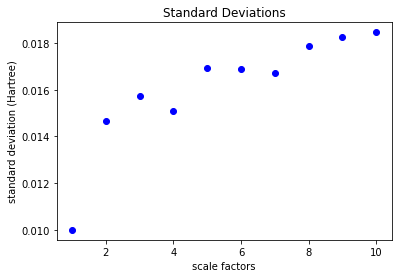

In [5]:
# Import the libraries
import matplotlib.pyplot as plt
#calculate standard deviations 
vqe_std = []
for i in range(10): 
    std = np.std(vqe_energies[i])
    vqe_std.append(std)
scales = [1,2,3,4,5,6,7,8,9,10]
plt.plot(scales, vqe_std, 'bo')
plt.title('Standard Deviations')
plt.xlabel('scale factors')
plt.ylabel('standard deviation (Hartree)')


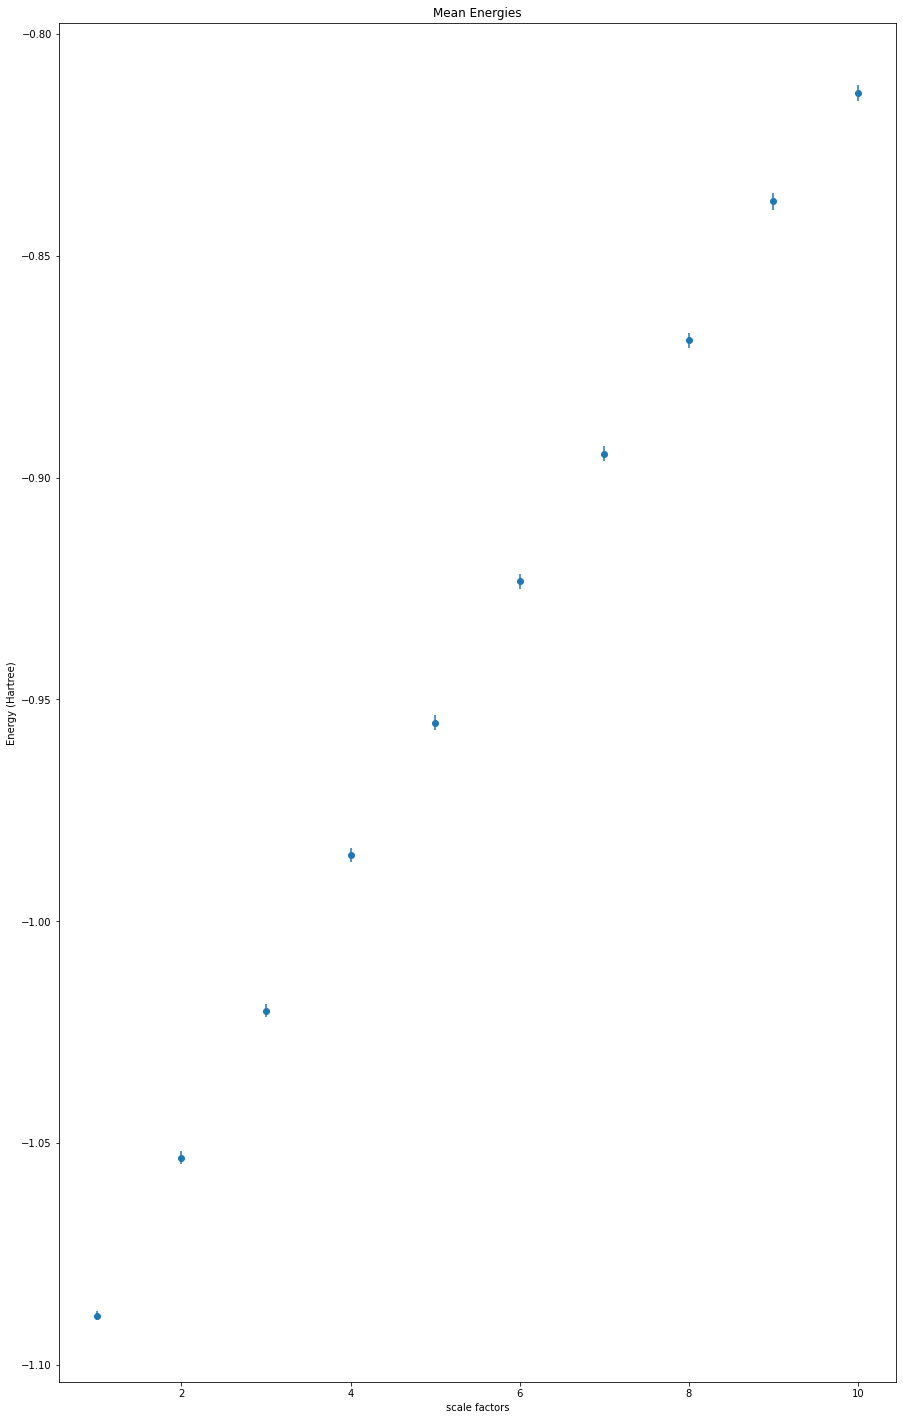

In [6]:
#calculate means and errors 
vqe_err  = [std/10 for std in vqe_std]
vqe_mean = []
for i in range(10): 
    mean = np.mean(vqe_energies[i])
    vqe_mean.append(mean)
scales = [1,2,3,4,5,6,7,8,9,10]
plt.figure(figsize=(15,25))
plt.errorbar(scales, vqe_mean, yerr=vqe_err,fmt ='o' )

plt.title('Mean Energies')
plt.xlabel('scale factors')
plt.ylabel('Energy (Hartree)')
plt.show()

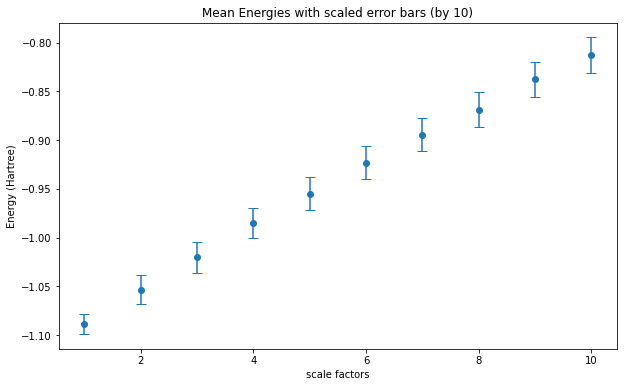

In [7]:
#Scaling errors to look at trends

plt.figure(figsize=(10,6))
plt.errorbar(scales, vqe_mean, yerr=[10*err for err in vqe_err], capsize = 5,fmt ='o' )

plt.title('Mean Energies with scaled error bars (by 10)')
plt.xlabel('scale factors')
plt.ylabel('Energy (Hartree)')
plt.show()

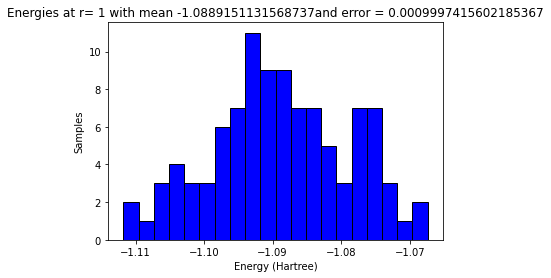

In [8]:
#Looking at a sample plot 
i = 0
# matplotlib histogram
plt.hist(vqe_energies[i], color = 'blue', edgecolor = 'black',
         bins = int(0.2/0.01))
plt.axvline(vqe_mean[i], 1, label='mean', color = 'k',linestyle = 'dashed', linewidth=1)
# Add labels
plt.title('Energies at r= '+ str(i+1) +' with mean ' + str(vqe_mean[i]) + 'and error = ' + str(vqe_err[i]))
plt.xlabel('Energy (Hartree)')
plt.ylabel('Samples')
plt.show()

## Functions for Richardson Extrap and computing Error on Zero noise

In [9]:
def RichardsonExtrap(energies): 
    """
    Input: An array of energies scaled with different stretch factors--normal integer multiples only --eg 1,2,3,4..
    Output: Zero Error extrapolated answer
    """
    n = len(energies)
    
    #setting up all equations 
    equations = []
    for eq_num in range(1,n+1): 
        equation = []
        if eq_num == 1: 
            for i in range(n): 
                equation.append(1)
            equations = [equation]
        else: 
            for term_num in range(1,n+1): 
                term = term_num**(eq_num-1)
                equation.append(term)
            equations = np.append(equations, [equation], axis = 0)
    #print(equations)
    
    #Now filling up equals to matrix 
    equals_to = [1]
    for i in range(1, n): 
        equals_to.append(0)
    #print(equals_to)
    
    #solving the system
    coeff = np.linalg.solve(equations, equals_to)
    #print(coeff)
    
    #Combine coeff with energies to get zero noise result 
    result = np.dot(coeff, energies)
    return result

In [10]:
def MonteCarloError(means, std_devs, poly_fit = False, deg = 1, sampling_size = 1000): 
    """
    Input: arrays means and standard deviations of the various scalings of noise, whether to do richardson i.e. no poly fit 
    If doing polyfit, then specify degree, sampling_size is how many times to sample from the Gaussian 
    
    Assumption: Scaled by integer values ranging from 1 to X where X>1
    
    Output: Error estimate
    """
    n = len(means)
    
    #Sampling from Gaussian for each scaling 
    all_samples = []
    debug_means = []
    for i in range(n): 
        samples = np.random.normal(means[i], std_devs[i], sampling_size)
        all_samples.append(samples)
        #for debugging
        debug_means.append(means[i] - np.mean(samples))
    #print(debug_means)
    
    #Doing Extrapolation for all sampling_size samples (1000 if set to default)
    zero_noise_energies = []
    for j in range(sampling_size): 
        energies = []
        for i in range(n): 
            energies.append(all_samples[i][j])
            
        ##Doing either richardson or funcs 
        ###Polynomial
        if poly_fit: 
            ####need the scale values: 
            scales = []
            for s in range(1, n+1): 
                scales.append(s)
            ####making the function 
            param = np.polyfit(scales, energies, deg)
            f = np.poly1d(param)
            ####extrapolation
            result = f(0)
            zero_noise_energies.append(result)
            
        ###Richardson
        else: 
            result = RichardsonExtrap(energies)
            zero_noise_energies.append(result)
    
    #Returning error i.e. std 
    error = np.std(zero_noise_energies)
    return error
    
        

## Finding Uncertainties on Zero Noise of Richard and Polynomial Fits

In [11]:
#Richardson Extrap Error(Uncertainity)
R_uncert = MonteCarloError(vqe_mean, vqe_std, poly_fit = False)

#Polynomial Fits Errors (Uncertainities)
poly_uncerts = []
num_poly = 8
for i in range(1, num_poly+1): 
    uncert = MonteCarloError(vqe_mean, vqe_std, poly_fit = True, deg = i)
    poly_uncerts.append(uncert)

### Finding Zero Noise Results

In [12]:
#Richardson 
R_zero = RichardsonExtrap(vqe_mean)


#Polynomial Curve Fitting (8th order)
from scipy.optimize import curve_fit
scales = [1,2,3,4,5,6,7,8,9,10]
funcs = []
for i in range(1,9): 
    param = np.polyfit(scales, vqe_mean, i)
    p = np.poly1d(param)
    funcs.append(p)

##Finding zero_noise
poly_zero = []
for f in funcs:
    poly_zero.append(f(0))

### Plotting Results 

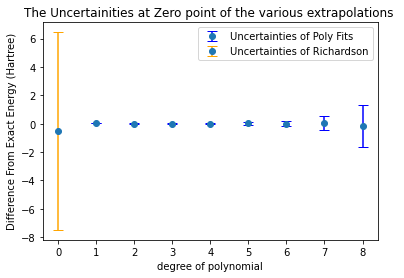

In [13]:
import matplotlib.pyplot as plt 
degrees = []
for i in range(num_poly): 
    degrees.append(i+1)
plt.errorbar(degrees, [energy - exact_energies[0] for energy in poly_zero], yerr=poly_uncerts, capsize = 5,fmt ='o', ecolor = 'blue', label = 'Uncertainties of Poly Fits' )
plt.errorbar(0, R_zero- exact_energies[0], yerr=R_uncert, capsize = 5,fmt ='o', ecolor = 'orange' , label = 'Uncertainties of Richardson')
plt.xlabel('degree of polynomial')
plt.ylabel('Difference From Exact Energy (Hartree)')
plt.title('The Uncertainities at Zero point of the various extrapolations ')
plt.legend()
plt.show()

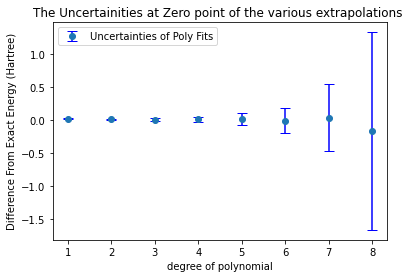

In [14]:
plt.errorbar(degrees, [energy - exact_energies[0] for energy in poly_zero], yerr=poly_uncerts, capsize = 5,fmt ='o', ecolor = 'blue', label = 'Uncertainties of Poly Fits' )
plt.xlabel('degree of polynomial')
plt.ylabel('Difference From Exact Energy (Hartree)')
plt.title('The Uncertainities at Zero point of the various extrapolations ')
plt.legend()
plt.show()

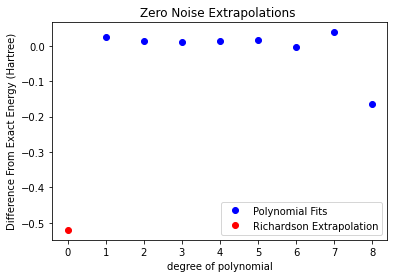

In [15]:
plt.plot(degrees, [energy - exact_energies[0] for energy in poly_zero], 'bo', label = 'Polynomial Fits' )
plt.plot(0, R_zero- exact_energies[0], 'ro' , label = 'Richardson Extrapolation')
plt.xlabel('degree of polynomial')
plt.ylabel('Difference From Exact Energy (Hartree)')
plt.title('Zero Noise Extrapolations ')
plt.legend()
plt.show()

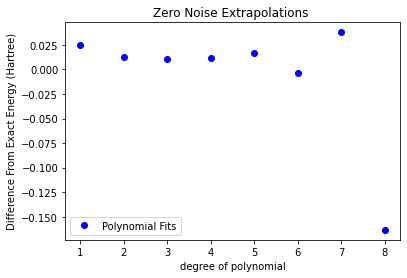

In [132]:
plt.plot(degrees, [energy - exact_energies[0] for energy in poly_zero], 'bo', label = 'Polynomial Fits')
plt.xlabel('degree of polynomial')
plt.ylabel('Difference From Exact Energy (Hartree)')
plt.title('Zero Noise Extrapolations ')
plt.legend()
plt.show()

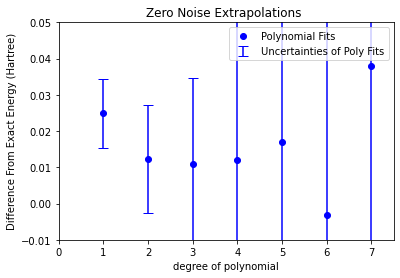

In [141]:
plt.errorbar(degrees[:-1], [poly_zero[i] - exact_energies[0] for i in range(len(poly_zero)-1)], yerr=poly_uncerts[:-1], capsize = 5,fmt =' ', ecolor = 'blue', label = 'Uncertainties of Poly Fits' )
plt.plot(degrees[:-1],[poly_zero[i] - exact_energies[0] for i in range(len(poly_zero)-1)] , 'bo', label = 'Polynomial Fits')
plt.axis([0,7.5,-0.01, 0.05])
plt.xlabel('degree of polynomial')
plt.ylabel('Difference From Exact Energy (Hartree)')
plt.title('Zero Noise Extrapolations ')
plt.legend()
plt.show()

In [17]:
poly_uncerts

[0.009563194707806175,
 0.014868476989128894,
 0.023867088619395953,
 0.04278943216312633,
 0.09007412112162969,
 0.18801849926191241,
 0.5051490483541832,
 1.4987506836441227]

In [18]:
R_uncert

6.971424239558951

### Curve Fitting

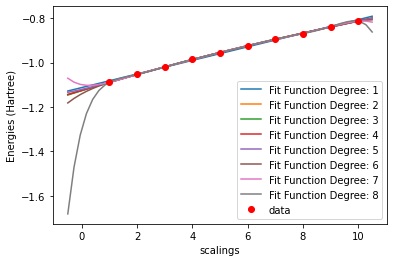

In [19]:
#Polynomial Curve Fitting (8th order)
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
scales = [1,2,3,4,5,6,7,8,9,10]
funcs = []
covs = []
for i in range(1,9): 
    param, cov = np.polyfit(scales, vqe_mean, i, cov = True)
    p = np.poly1d(param)
    funcs.append(p)
    covs.append(cov)
x = np.linspace(-0.5, 10.5, 50)
for p in funcs: 
    plt.plot(x, p(x), label='Fit Function Degree: ' + str(p.order))
plt.plot(scales, vqe_mean, 'ro',label='data')
plt.xlabel('scalings')
plt.ylabel('Energies (Hartree)')
plt.legend()
plt.show()


# Curve-Fitting: Does Accounting for Fit Error Affect Chi and F?

## Making Uncertainty Function

In [50]:
def ErrorOnPoint(func, cov, x): 
    """
    Input: Function, covariance matrix and x point to compute error at 
    Output: Error ---scalar value
    """
    #Gradient 
    degree = func.order
    grad = []
    for d in range(degree+1): 
        term = x**d
        grad.append([term])
    #print(grad)
    
    #Covariance Matrix Calc
    err_sq = (np.matmul(np.transpose(grad), np.matmul(cov, grad))).item()
    #print(err_sq)
    err = np.sqrt(err_sq)
    return err

In [51]:
#Sanity Check 
poly_uncerts_at_zero = []
for i in range(8): 
    uncert = ErrorOnPoint(funcs[i], covs[i], 0)
    poly_uncerts_at_zero.append(uncert)
print(poly_uncerts_at_zero)
print(poly_uncerts)

[0.0005342110694169097, 5.909732331575287e-05, 2.5520210336066475e-05, 1.1983241593751154e-05, 5.931535987775976e-06, 2.863152474494471e-06, 1.6729123150625502e-06, 5.640794847835521e-07]
[0.009563194707806175, 0.014868476989128894, 0.023867088619395953, 0.04278943216312633, 0.09007412112162969, 0.18801849926191241, 0.5051490483541832, 1.4987506836441227]


In [62]:
#Filling up all uncertainities for all points and all functions 
uncert = []
for i in range(8): 
    func_uncert = []
    for j in range(1, 11): 
        err = ErrorOnPoint(funcs[i], covs[i], j)
        func_uncert.append(err)
    print(func_uncert)
    uncert.append(func_uncert)

[0.002851906695632837, 0.006160822596816535, 0.00947377808866331, 0.012787633886375181, 0.016101834134211127, 0.01941620244780797, 0.022730665310056897, 0.026045186624716776, 0.029359746595121857, 0.03267433345728961]
[0.001067684372169729, 0.00525062340697951, 0.012629583316907708, 0.023203222738647, 0.03697131569513247, 0.053933792127470445, 0.07409062323206285, 0.09744179499495785, 0.12398729978045132, 0.15372713307344832]
[0.0012873118596142578, 0.015229193162347027, 0.05834960848401058, 0.14716217790371097, 0.2981826151460401, 0.5279269409490012, 0.8529112565010839, 1.2896516915639213, 1.8546643881320093, 2.564465494150763]
[0.0014888568861162754, 0.045177370381216574, 0.281115825850846, 0.9812304053149092, 2.5394140143574084, 5.471522471984182, 10.415373894263825, 18.130748556059668, 29.4993888483305, 45.52499926196154]
[0.001642627587706218, 0.13967002302353015, 1.4361974415155077, 6.976882018848927, 23.122520372437446, 60.720404964512056, 136.31569423807653, 273.3627845873046, 

In [63]:
uncert

[[0.002851906695632837,
  0.006160822596816535,
  0.00947377808866331,
  0.012787633886375181,
  0.016101834134211127,
  0.01941620244780797,
  0.022730665310056897,
  0.026045186624716776,
  0.029359746595121857,
  0.03267433345728961],
 [0.001067684372169729,
  0.00525062340697951,
  0.012629583316907708,
  0.023203222738647,
  0.03697131569513247,
  0.053933792127470445,
  0.07409062323206285,
  0.09744179499495785,
  0.12398729978045132,
  0.15372713307344832],
 [0.0012873118596142578,
  0.015229193162347027,
  0.05834960848401058,
  0.14716217790371097,
  0.2981826151460401,
  0.5279269409490012,
  0.8529112565010839,
  1.2896516915639213,
  1.8546643881320093,
  2.564465494150763],
 [0.0014888568861162754,
  0.045177370381216574,
  0.281115825850846,
  0.9812304053149092,
  2.5394140143574084,
  5.471522471984182,
  10.415373894263825,
  18.130748556059668,
  29.4993888483305,
  45.52499926196154],
 [0.001642627587706218,
  0.13967002302353015,
  1.4361974415155077,
  6.976882018

### This does not make sense, reverting to Monte Carlo Procedure (THIS IS WRONG A BUG BEWARE)

In [69]:
def MonteCarloErrorAtArbitPoint(means, std_devs, deg = 1, sampling_size = 1000, x=0): 
    """
    Input: arrays means and standard deviations of the various scalings of noise, degree of fit, 
            sampling_size is how many times to sample from the Gaussian ,x is point at which to 
            approx error
    Assumption: Scaled by integer values ranging from 1 to X where X>1
    
    Output: Error estimate
    """
    n = len(means)
    
    #Sampling from Gaussian for each scaling 
    all_samples = []
    debug_means = []
    for i in range(n): 
        samples = np.random.normal(means[i], std_devs[i], sampling_size)
        all_samples.append(samples)
        #for debugging
        debug_means.append(means[i] - np.mean(samples))
    #print(debug_means)
    
    #Doing Extrapolation for all sampling_size samples (1000 if set to default)
    x_noise_energies = []
    for j in range(sampling_size): 
        energies = []
        for i in range(n): 
            energies.append(all_samples[i][j])
            
        
    ##Polynomial
        ####need the scale values: 
        scales = []
        for s in range(1, n+1): 
            scales.append(s)
        ####making the function 
        param = np.polyfit(scales, energies, deg)
        f = np.poly1d(param)
        ####extrapolation
        result = f(0)
        x_noise_energies.append(result)
            
    
    #Returning error i.e. std 
    error = np.std(x_noise_energies)
    return error

In [71]:
#Filling up all uncertainities for all points and all functions 
uncert = []
for i in range(8): 
    func_uncert = []
    for j in range(1, 11): 
        err = MonteCarloErrorAtArbitPoint(vqe_mean, vqe_std, deg = i+1, sampling_size = 1000, x=j)
        func_uncert.append(err)
    uncert.append(func_uncert)

In [72]:
uncert

[[0.0096528011536497,
  0.009893709625351752,
  0.009893250691396847,
  0.009464611871496576,
  0.010003428403628155,
  0.009570229438702796,
  0.010028505281198516,
  0.009254914678229918,
  0.009840859997479127,
  0.009577847513469812],
 [0.0159972706438396,
  0.015726098450131513,
  0.015475910371597271,
  0.01566962295165712,
  0.014894795649450903,
  0.01500046534904177,
  0.015114502781501822,
  0.01532982060297998,
  0.015710689772124555,
  0.015459568872977322],
 [0.024073589734193313,
  0.025165615173668793,
  0.02432473596865894,
  0.0240412590099856,
  0.023839319592257508,
  0.025191149099296057,
  0.023755046019088167,
  0.023470929806155685,
  0.024797939520670893,
  0.02316882463078993],
 [0.042999660078557364,
  0.04419912926784863,
  0.045079405798068746,
  0.04359029641885859,
  0.04234610396233317,
  0.041008532585914075,
  0.04257717524485797,
  0.04429561567335666,
  0.0442740007140494,
  0.044301981536067916],
 [0.08679714836766213,
  0.08304629840379343,
  0.0880

## Without Fit Error

In [73]:
#scaled chi square stats 
def chisq(arr_one , arr_two, arr_std, ddof): 
    chi_sq =0
    for i in range(len(arr_one)):
        chi_sq += (((arr_one[i]-arr_two[i])**2)/ (arr_std[i]**2))
    return (100*chi_sq)/ddof
for p in funcs:
    print("Chi Square Statistics for polynomial fit of degree " +str(p.order)+  ":" )
    print(str(chisq(vqe_mean, p(scales), vqe_std, 9-p.order)))

Chi Square Statistics for polynomial fit of degree 1:
12.387340324169841
Chi Square Statistics for polynomial fit of degree 2:
0.6255631545165113
Chi Square Statistics for polynomial fit of degree 3:
0.6782915979357725
Chi Square Statistics for polynomial fit of degree 4:
0.7854383214703204
Chi Square Statistics for polynomial fit of degree 5:
0.9353463688247432
Chi Square Statistics for polynomial fit of degree 6:
0.9101707497966519
Chi Square Statistics for polynomial fit of degree 7:
1.106545506783799
Chi Square Statistics for polynomial fit of degree 8:
0.26342745816137464


In [74]:
import scipy
num_scales = 10
# F-statistic calculator without zero error energy: 
def F_stat(deg_one, deg_two):
    num =( chisq_(deg_one) - chisq_(deg_two))/(deg_two -deg_one )
    denum= (chisq_(deg_two))/(num_scales - (deg_two+1))
    return num/denum
def chisq_(deg): 
    obs = funcs[deg-1](scales)
    exp = vqe_mean
    err = vqe_err
    chisq=0
    for i in range(len(scales)): 
        chisq+=((obs[i] - exp[i])**2)/((err[i])**2)
    return chisq
def F_checker(f_stat, df_1, df_2):
    alpha = 0.05
    p_val = scipy.stats.f.cdf(f_stat, df_1, df_2)
    #print('p val is ' + str(p_val))
    if (p_val<= alpha):
        print('More param is bad!')
    else: 
        print('More param is good!')
#calculating f stats of adjacent degrees
f_stats = []
for i in range(len([1,2,3,4,5,6,7])):
    f = F_stat(i+1,i+2)
    print('F stat for degree ' + str(i+1) +' vs '+ str(i+2) + ':')
    print(f)
    F_checker(f, num_scales -(i+1+1), num_scales -(i+2+1))
    
    f_stats.append(f)


F stat for degree 1 vs 2:
151.41521655787207
More param is good!
F stat for degree 2 vs 3:
0.4558400766601016
More param is good!
F stat for degree 3 vs 4:
0.1815011775796318
More param is bad!
F stat for degree 4 vs 5:
0.19864954656967757
More param is good!
F stat for degree 5 vs 6:
1.1106413012446998
More param is good!
F stat for degree 6 vs 7:
0.46760050323303426
More param is good!
F stat for degree 7 vs 8:
7.401140219072634
More param is good!


## With Fit Error 

In [76]:
def chisq_(deg): 
    obs = funcs[deg-1](scales)
    exp = vqe_mean
    data_err = vqe_err
    fit_err = uncert[deg-1]
    chisq=0
    for i in range(len(scales)): 
        chisq+=((obs[i] - exp[i])**2)/((data_err[i])**2 + (fit_err[i])**2)
    return chisq
for i in range(1, 9):
    print("Chi Square Statistics for polynomial fit of degree " +str(i)+  ":" )
    ddof = 9-i
    print(str(chisq_(i)/ddof))

Chi Square Statistics for polynomial fit of degree 1:
0.24637942424277542
Chi Square Statistics for polynomial fit of degree 2:
0.007645224337669925
Chi Square Statistics for polynomial fit of degree 3:
0.0034658439272830955
Chi Square Statistics for polynomial fit of degree 4:
0.0012216346724364994
Chi Square Statistics for polynomial fit of degree 5:
0.00037322627824058763
Chi Square Statistics for polynomial fit of degree 6:
7.346312389792362e-05
Chi Square Statistics for polynomial fit of degree 7:
1.1595271998721967e-05
Chi Square Statistics for polynomial fit of degree 8:
3.1851147553735645e-07


In [84]:
num_scales = 10
# F-statistic calculator without zero error energy: 
def F_stat(deg_one, deg_two):
    num =( chisq_(deg_one) - chisq_(deg_two))/(deg_two -deg_one )
    denum= (chisq_(deg_two))/(num_scales - (deg_two+1))
    return num/denum
def F_checker(f_stat, df_1, df_2):
    alpha = 0.05
    p_val = scipy.stats.f.cdf(f_stat, df_1, df_2)
    print('p val is ' + str(p_val))
    if (p_val<= alpha):
        print('More param is bad!')
    else: 
        print('More param is good!')
#calculating f stats of adjacent degrees
f_stats = []
for i in range(len([1,2,3,4,5,6,7])):
    f = F_stat(i+1,i+2)
    print('F stat for degree ' + str(i+1) +' vs '+ str(i+2) + ': ' + str(f))
    F_checker(f, num_scales -(i+1+1), num_scales -(i+2+1))
    
    f_stats.append(f)


F stat for degree 1 vs 2: 250.81263006638287
p val is 0.9999999341096651
More param is good!
F stat for degree 2 vs 3: 9.441136844740026
p val is 0.9929105057821375
More param is good!
F stat for degree 3 vs 4: 12.022325931715482
p val is 0.9923356625223326
More param is good!
F stat for degree 4 vs 5: 12.365871639523386
p val is 0.9848170366477945
More param is good!
F stat for degree 5 vs 6: 17.321829970594898
p val is 0.9793900195118783
More param is good!
F stat for degree 6 vs 7: 17.006830690824863
p val is 0.9439550915247044
More param is good!
F stat for degree 7 vs 8: 71.8091317850306
p val is 0.9168449883628543
More param is good!


# How Consistent are the pattern among uncertainties as we vary orders?

In [122]:
def UncertAtZeroAcrossOrder(order): 
    """
    Input: Order (int)
    Return: Plot of uncert of Richie and polys at zero using (order+1 ) energies
    """
    fig = plt.figure()
    num_funcs = order
    energies = vqe_mean[: order+1]
    std_dev = vqe_std[: order+1]
    scales = [num for num in range(1, order+2)]
    func_deg = [i+1 for i in range(num_funcs)]
    
    #Energy At Zero 
    
    ##Richardson 
    R_energy = RichardsonExtrap(energies)
    
    ##Polynomials
    funcys = []
    covys = []
    func_en =[]
    for i in range(num_funcs): 
        degree = i+1
        param= np.polyfit(scales, energies, degree)
        f = np.poly1d(param)
        funcys.append(f)
        covys.append(cov)
        func_en.append(f(0))
    
    #Uncertainties at Zero 
    
    ##Richardson 
    R_uncert = MonteCarloError(energies, std_dev, poly_fit = False)
    
    ##Polynomials 
    func_uncert = []
    for i in range(num_funcs): 
        uncert =  MonteCarloErrorAtArbitPoint(energies, std_dev, deg = i+1, sampling_size = 1000, x=0)
        func_uncert.append(uncert)
    
    #Plotting 
    #plt.yticks(np.arange(-1, 1, 0.01), figure = fig)
    ##Richardson 
    plt.errorbar(0, R_zero- exact_energies[0], yerr=R_uncert, capsize = 5,fmt =' ', ecolor = 'red' , label = 'Uncertainties of Richardson', figure = fig)
    plt.plot(0, R_zero- exact_energies[0],  'ro', figure = fig)
    
    ##Polynomials 
    plt.errorbar(func_deg, [energy - exact_energies[0] for energy in func_en], yerr=func_uncert, capsize = 5,fmt =' ', ecolor = 'blue', label = 'Uncertainties of Poly Fits', figure = fig)
    plt.plot(func_deg, [energy - exact_energies[0] for energy in func_en], 'bo', figure = fig)
    
    plt.xlabel('degree of polynomial', figure = fig)
    plt.ylabel('Difference From Exact Energy (Hartree)', figure = fig)
    plt.legend()
    plt.title('Order '+ str(order)+': The Uncertainities at Zero point of the various extrapolations ', figure = fig)
    
    return fig
        

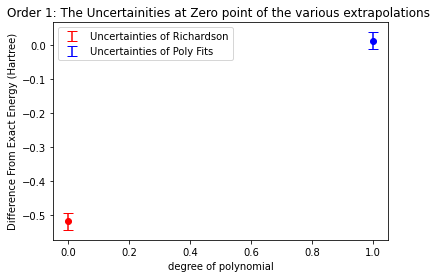

In [123]:
# First Order 
plot = UncertAtZeroAcrossOrder(1)
plot.show()

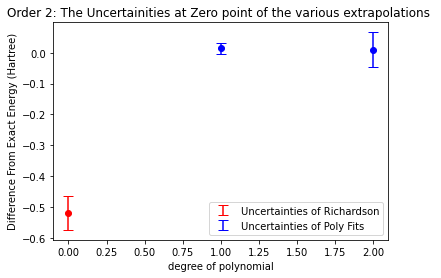

In [124]:
# Second Order 
plot = UncertAtZeroAcrossOrder(2)
plot.show()

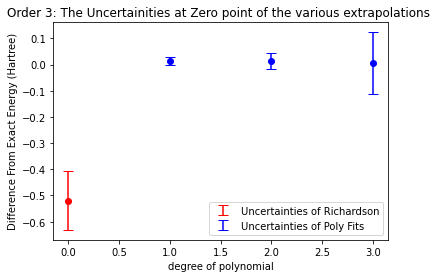

In [125]:
# Third Order 
plot = UncertAtZeroAcrossOrder(3)
plot.show()

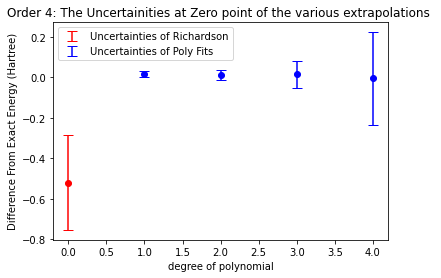

In [126]:
# Fourth Order 
plot = UncertAtZeroAcrossOrder(4)
plot.show()

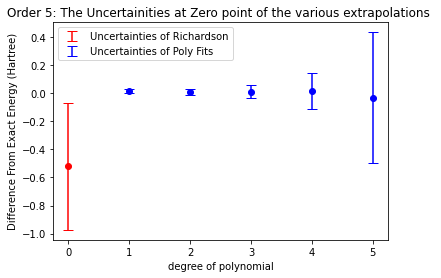

In [127]:
# Fifth Order 
plot = UncertAtZeroAcrossOrder(5)
plot.show()

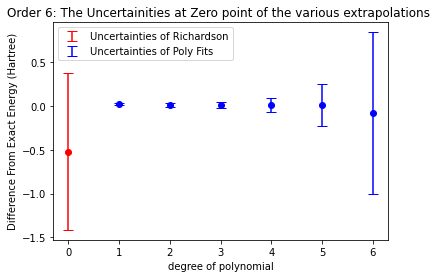

In [128]:
# Sixth Order 
plot = UncertAtZeroAcrossOrder(6)
plot.show()

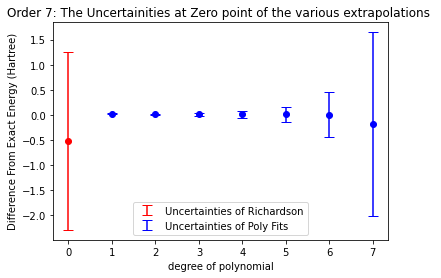

In [129]:
# Seventh Order 
plot = UncertAtZeroAcrossOrder(7)
plot.show()

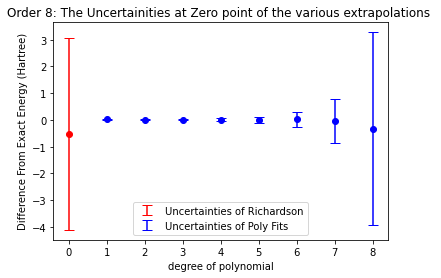

In [130]:
# Eighth Order 
plot = UncertAtZeroAcrossOrder(8)
plot.show()

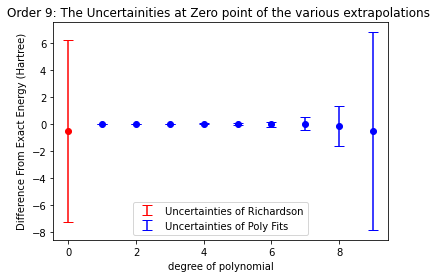

In [131]:
# Ninth Order 
plot = UncertAtZeroAcrossOrder(9)
plot.show()